Universidad Galileo

Statistical Learning I

PAPD - Sección V

Sergio José Barrios Martínez

Carnet No. 19012765

# Práctica No. 4
## Regresión Logística

Modelo de Clasificación Multiclase (CROSS ENTROPY + SOFTMAX)


In [57]:
import tensorflow as tf
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")
from tensorflow import keras

import numpy as np
import datetime
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from tempfile import TemporaryFile

Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,000 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist

In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

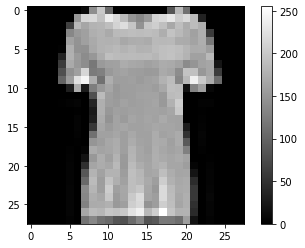

In [4]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [5]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

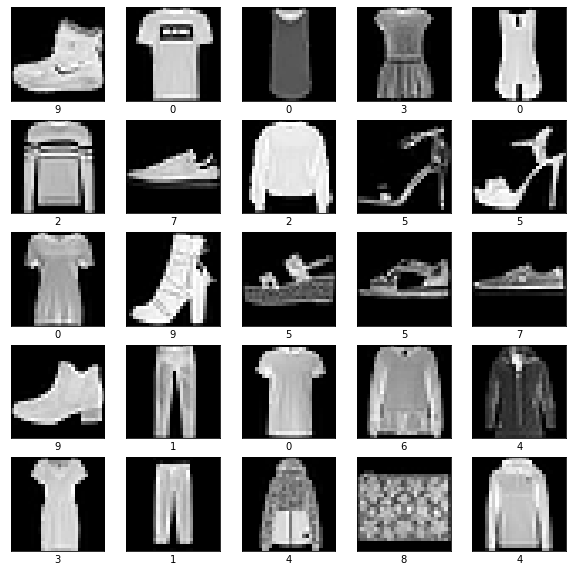

In [6]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Selección de 3 Clases Arbitrarias del Dataset

En este caso elegiremos **Trouser, Shirt y Bag**. Por lo que se aplicará el filtro para los conjuntos train_images, train_labels, test_images y test_labels.


| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

In [7]:
filtro = (train_labels == 1) | (train_labels == 6) | (train_labels == 8)
etiquetas_entrenamiento = train_labels[filtro]
imagenes_entrenamiento = train_images[filtro]

Ahora, se creará un diccionario para relacionar el valor numérico de las etiquetas con su descripción

In [8]:
descripcion = ['Trouser','Shirt','Bag']
numero_etiqueta = [1,6,8]
diccionario = dict(zip(numero_etiqueta,descripcion))
diccionario

{1: 'Trouser', 6: 'Shirt', 8: 'Bag'}

### Preparación del Vectores de Características a partir de Imagenes

Dado que cada imagen está representada por una matriz de 28 x 28, se necesita un cambio de forma, para tener un solo vector que contenga todos sus elementos. 
En este caso particular: 28 x 28 = 784.
Por este motivo, se encuentra la forma del conjunto de entrenamiento (que está en tres dimensiones) y se transforma a un conjunto de dos dimensiones. Para este caso particular, la segunda dimensión será 784. Al agregar un vector vertical de 1's para poder hacer el cálculo vectorizado, la segunda dimensión será 785.


In [9]:
# Forma original del Set de Entrenamiento
filas,longitud,altura = np.shape(imagenes_entrenamiento)

# Cambio de forma matriz características a vector características
matriz_x = np.reshape(imagenes_entrenamiento,(filas,longitud*altura))

# Preparación de Matriz X para cálculo vectorizado en la forma Y=X*W para (Y=mX+b)
unos = np.ones((filas, 1)) 
matriz_x = np.concatenate((matriz_x,unos),axis=1)
np.shape(matriz_x)

(18000, 785)

### Preparación de Tensor de Etiquetas

En este caso, nuestro vector de etiquetas ya tiene codificación numérica (dada por el número que identifica la clase). Se necesita entonces preparar la matriz Y con one-hot enconding, de la siguiente forma:
- 1 en la posición 0 para 'Trouser'
- 1 en la posición 1 para 'Shirt'
- 1 en la posición 2 para 'Bag'

Al solamente tener 3 categorías, el número de columnas será tres.

In [10]:
vector_y= np.expand_dims(etiquetas_entrenamiento,axis=1)
np.shape(vector_y)

(18000, 1)

In [11]:
from sklearn.preprocessing import OneHotEncoder
# se crea una instancia de one-hot-encoder
codificador = OneHotEncoder(handle_unknown='ignore')
# valores codificados para las tres categorías: 1:'Trouser'->[0]; 6:'Shirt'->[1]; 8:'Bag'->[2]
etiquetas_y = codificador.fit_transform(vector_y).toarray()

etiquetas_y

array([[1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

## TensorFlow

Se definirá el grafo para calcular regresión logística

### Definición del Grafo de Cómputo

In [12]:
grafo = tf.Graph()

with grafo.as_default():
    
    # Placeholders
    learning_rate = tf.placeholder(tf.float32,name="lr") # Hiper-parámetro de Tasa de Aprendizaje
    tensor_x = tf.placeholder(tf.float32,[None,785],"tensor_x") # Placeholder de Matriz de Features e Intercepto.
    tensor_y = tf.placeholder(tf.float32,[None,3],"tensor_y") # Placeholder de Predicción de Probabilidades.

    # Parámetros Entrenables del Modelo 
    W = tf.get_variable(name="W",dtype=tf.float32,shape=[785,3],initializer=tf.zeros_initializer())

    # Cálculo vectorizado del Modelo Y = x*W
    with tf.name_scope("modelo_lineal"):
        logits = tf.matmul(tensor_x,W) # Hipótesis del modelo

    with tf.name_scope("error_modelo"):
        # Cálculo vectorizado del Error de la Hipótesis (LOGITS->SOFTMAX->CROSS ENTROPY)
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=tensor_y))
        error_summary = tf.summary.scalar("error",error)

    with tf.name_scope("gradiente_error"):
        # Gradiente sobre la función de costo J(m1,m2,m3,m4,m5,...,m724,b)
        gradiente = tf.gradients(error,[W]) # Se usa la auto-diferenciación de TensorFlow

    with tf.name_scope("actualizacion_parametros"):
        # Actualización Vectorizada de parámetros (m1,m2,m3,...,m784,b)
        actualizacion_parametros = tf.assign(W,W - learning_rate*gradiente[0])

    with tf.name_scope("predicciones"):
        predicciones_entrenamiento = tf.nn.softmax(logits)
    
    with tf.name_scope("accuracy"):
        numero_aciertos = tf.equal(tf.argmax(predicciones_entrenamiento,1), tf.argmax(tensor_y,1))      
        exactitud = tf.reduce_mean(tf.cast(numero_aciertos, tf.float32))
        exactitud_summary = tf.summary.scalar("accuracy",exactitud)
    
    init = tf.global_variables_initializer()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Grafo
<img src="./imagenes/Grafo.png">



### Despliegue de Grafo
<img src="./imagenes/Grafo_Desplegado.png">

### Entrenamiento con Mini-Batch Gradient Descent Vectorizado

In [63]:
# Función de Entrenamiento con Mini-Batch Gradient Descent (parámetros Learning Rate, Número de Iteraciones y Tamaño del Batch)
def entrenamiento(X,Y,lr,iteraciones,batch_size):
    
    now = datetime.datetime.now()
    tamaño_muestra = len(Y)
    total_iteraciones = int(tamaño_muestra/batch_size)
    
    
    tf.reset_default_graph()
    
    with tf.Session(graph=grafo) as session:

        # String de Configuración 
        #("Año""Mes""Dia"-"Hora""Minuto""Segundo"-"lr=""valor Learning Rate"-"it=""iteracion")
        writer = tf.summary.FileWriter('./graphs/'+now.strftime("%Y%m%d-%H%M%S")+'-lr='+str(lr) \
                                       +'-it='+str(iteraciones)+'-bs='+str(batch_size), session.graph)
 
        session.run(init) # Inicialización de Variables

        feed_dict = {tensor_x:X,tensor_y:Y,learning_rate:lr}
        predicciones = session.run(logits,feed_dict=feed_dict)

        for i in range(iteraciones):

            if (i+1) % 1 == 0 or i == 0:

                cross_entropy_summary = session.run(error_summary,feed_dict=feed_dict)
                writer.add_summary(cross_entropy_summary, i) # Escalar del Error Medio del Cross Entropy
                
                accuracy_summary = session.run(exactitud_summary,feed_dict=feed_dict)
                writer.add_summary(accuracy_summary, i) # Escalar del Accuracy
         
            # Mini-Batch Gradient Descent
            for j in range(total_iteraciones):
                muestra_inicio = j*batch_size
                muestra_fin = muestra_inicio + batch_size
                feed_dict = {tensor_x:X[muestra_inicio:muestra_fin],\
                             tensor_y:Y[muestra_inicio:muestra_fin],\
                             learning_rate:lr}
                session.run(actualizacion_parametros,feed_dict=feed_dict)
                   
            feed_dict = {tensor_x:X,tensor_y:Y,learning_rate:lr}
            predicciones = session.run(logits,feed_dict=feed_dict)
            
        writer.close()
        
        # Guardamos el modelo en un archivo .npy para futuras predicciones
        np.save('D:\OneDrive - Universidad Galileo\Data Science\Python\Proyectos\Galileo\Tarea No. 4\Fashion_mnist\parametros.npy', session.run([W]))

## Ejecución con Datos Crudos

Se mostrará el proceso para datos crudos.

In [17]:
entrenamiento(matriz_x,etiquetas_y,0.0001,200,32)

#### Resultados


<img src="./imagenes/Error_crudo.png">


<img src="./imagenes/Accuracy_Crudo.png">

## Grafo con Pre-procesamiento de Datos (Normalización y Escalado)
Se modifica el grafo anterior, para incluir las funciones de pre-procesamiento para transformar los datos X de entrada con:
- Escalado
- Normalización

NOTA: Debido a la necesidad de transformar las features contenidas en los datos X, se modificará el grafo para hacer el *escalado* y la *normalización* únicamente sobre las features del tensor X de entrada (es decir, sin la columna de 1's añadida). De lo contrario, la columna de 1's sería incluida en el escalamiento y normalización junto con las features de X's, lo cual sería incorrecto.


In [107]:
grafo = tf.Graph()

with grafo.as_default():
    
    # Placeholders
    learning_rate = tf.placeholder(tf.float64,name="lr") # Hiper-parámetro de Tasa de Aprendizaje
    tensor_x = tf.placeholder(tf.float64,[None,784],"tensor_x") # Placeholder de Matriz de Features SIN Intercepto.
    tensor_y = tf.placeholder(tf.float64,[None,3],"tensor_y") # Placeholder de Predicción de Probabilidades.

    # Parámetros Entrenables del Modelo 
    W = tf.get_variable(name="W",dtype=tf.float64,shape=[785,3],initializer=tf.zeros_initializer())
    
    # Constante (añadiremos 1's a la matriz de entrada X para el intercepto)
    tensor_unos = tf.constant(1.0,dtype=tf.float64)[None, None]  # Se expanderá la dimensión posteriormente
    
    # Escalado del tensor_x
    with tf.name_scope("escalado"):
        tensor_x_rango = tf.cast(tf.subtract(tf.reduce_max(tensor_x),tf.reduce_min(tensor_x)),tf.float64)
        tensor_x_escalado = tf.cast(tf.math.truediv(tf.subtract(tensor_x ,tf.reduce_min(tensor_x)),tensor_x_rango),tf.float64)
        
    # Normalización del tensor_x
    with tf.name_scope("normalizacion"):
        tensor_x_normalizado = tf.truediv(tf.subtract(tensor_x_escalado,tf.reduce_mean(tensor_x_escalado)),tf.math.reduce_std(tensor_x_escalado))
        
    # Añadir Columna de 1's a tensor_x
    with tf.name_scope("unos_intercepto"):
        tensor_unos = tf.tile(tensor_unos,[tf.shape(tensor_x_normalizado)[0],1])  # Se repiten filas con 1's
        tensor_x_transformado = tf.concat([tensor_x_normalizado,tensor_unos],axis=1)
        
    # Cálculo vectorizado del Modelo Y = x*W
    with tf.name_scope("modelo_lineal"):
        logits = tf.matmul(tensor_x_transformado,W) # Hipótesis del modelo

    with tf.name_scope("error_modelo"):
        # Cálculo vectorizado del Error de la Hipótesis (LOGITS->SOFTMAX->CROSS ENTROPY)
        error = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=tensor_y))
        error_summary = tf.summary.scalar("error",error)

    with tf.name_scope("gradiente_error"):
        # Gradiente sobre la función de costo J(m1,m2,m3,m4,m5,...,m724,b)
        gradiente = tf.gradients(error,[W]) # Se usa la auto-diferenciación de TensorFlow

    with tf.name_scope("actualizacion_parametros"):
        # Actualización Vectorizada de parámetros (m1,m2,m3,...,m784,b)
        actualizacion_parametros = tf.assign(W,W - learning_rate*gradiente[0])

    with tf.name_scope("predicciones"):
        predicciones_entrenamiento = tf.nn.softmax(logits)
    
    with tf.name_scope("accuracy"):
        numero_aciertos = tf.equal(tf.argmax(predicciones_entrenamiento,1), tf.argmax(tensor_y,1))      
        exactitud = tf.reduce_mean(tf.cast(numero_aciertos, tf.float64))
        exactitud_summary = tf.summary.scalar("accuracy",exactitud)
    
    init = tf.global_variables_initializer()

### Grafo con Transformación de Datos de Entrada
#### Escalado y Normalización
<img src="./imagenes/Grafo_completo.png">


#### Detalle de Transformación
<img src="./imagenes/Transformacion.png">



Se harán los cálculos para poder hacer la comparativa entre:
- Entrenamiento con Datos Crudos
- Entrenamiento con Datos Escalados
- Entrenamiento con Datos Escalados y Normalizados

In [108]:
# Forma original del Set de Entrenamiento
filas,longitud,altura = np.shape(imagenes_entrenamiento)

# Cambio de forma matriz características a vector características
matriz_x = np.reshape(imagenes_entrenamiento,(filas,longitud*altura))

# Entrenamiento
entrenamiento(matriz_x,etiquetas_y,0.0001,200,32)


### Comparativa de Resultados

- Naranja: Datos Crudos
- Azul: Datos Escalados
- Corinto: Datos Escalados y Normalizados

#### Error
<img src="./imagenes/Error_completo.png">

#### Accuracy
<img src="./imagenes/Accuracy_completo.png">



### Conclusiones Comparativa
- El progreso del entrenamiento fue significativamente más rápido para lograr la convergencia del error utilizando datos transformados. 
- Puede verse que con el escalado únicamente la curva se "suavizó" bastante y permitió que el error mostrara una tendencia descendente mucho más estable que con datos crudos.
- Con la normalización sobre estos datos escalados, la convergencia del error se aceleró aún más, permitiendo converger y estabilizar de forma más eficiente que con las otras dos corridas.
- Se concluye con estos resultados que las transformación de datos de entrada **(escalado + normalización)** ayudan a la estabilidad y velocidad de la minimización de la función de costo con el método de Gradient Descent.

In [188]:
# Filtramos el DataSet Original de Pruebas (TEST) para obtener las prendas seleccionadas en el entrenamiento
filtro = (test_labels == 1) | (test_labels == 6) | (test_labels == 8)
etiquetas_prueba = test_labels[filtro]
imagenes_prueba = test_images[filtro]

In [218]:
# Función de Identificación de Imágenes
def identificacion(imagen_X):
    
    # Importamos el modelo entrenado
    W = np.load('parametros.npy')
    
    # Forma original del vector prueba
    longitud,altura = np.shape(imagen_X)

    # Cambio de forma matriz características a vector características
    X = np.reshape(imagen_X,(1,longitud*altura))
       
    # Forma original del Set de Entrenamiento
    longitud,altura = np.shape(X)
    
    # Escalado
    X = (X - np.min(X))/(np.max(X)-np.min(X))
    
    # Normalización
    X = (X - np.mean(X))/np.std(X)
    

    # Preparación de Matriz X para cálculo vectorizado en la forma Y=X*W para (Y=mX+b)
    unos = np.ones((1, 1)) 
    X = np.concatenate((X,unos),axis=1)
    
    # Logits
    logits = np.matmul(X,W[0])
    
    # Softmax para obtener arreglo de probabilidades
    exps = [np.exp(i) for i in logits]
    sum_of_exps = np.sum(exps)
    softmax = exps/sum_of_exps
    
    # Diccionario
    descripcion = ['Trouser','Shirt','Bag']
    numero_etiqueta = [0,1,2]
    diccionario = dict(zip(numero_etiqueta,descripcion))

    
     # Se grafica la imagen
    plt.imshow(imagen_X, cmap = 'gray')
    plt.colorbar()
    plt.title(diccionario[np.argmax(softmax)])
    plt.show()
    
    print('La probabilidad es del:',np.around(np.max(softmax)*100,2),"%")
    print('------------------------------------------')
    

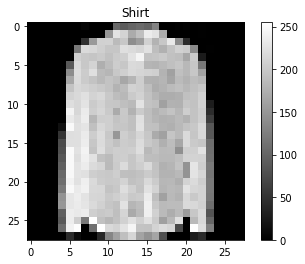

La probabilidad es del: 99.68 %
------------------------------------------


In [219]:
identificacion(imagenes_prueba[14])

### Muestra Aleatoria para Test del Modelo de Clasificación
Para esto se creará una función que genera números aleatorios (con distribución uniforme) en el rango del conjunto de imágenes de prueba (TEST), y luego itere utilizando la función de clasificación.

In [220]:
def muestreo_aleatorio(imagenes):
    
    import random
    
    #Se generan 5 números aleatorios en el rango del número de imagenes en el conjunto
    lista_aleatoria = random.sample(range(0, np.shape(imagenes)[0]), 5)
    
    for i in lista_aleatoria:
        print("Imagen No.",i,":")
        identificacion(imagenes[i])
    

Imagen No. 2636 :


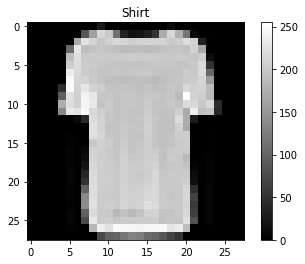

La probabilidad es del: 99.95 %
------------------------------------------
Imagen No. 2038 :


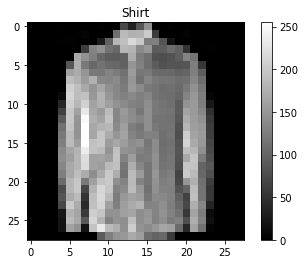

La probabilidad es del: 98.59 %
------------------------------------------
Imagen No. 2057 :


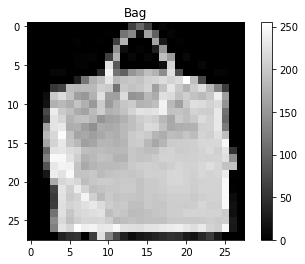

La probabilidad es del: 98.25 %
------------------------------------------
Imagen No. 248 :


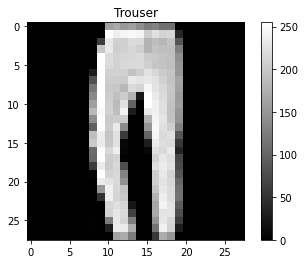

La probabilidad es del: 99.98 %
------------------------------------------
Imagen No. 706 :


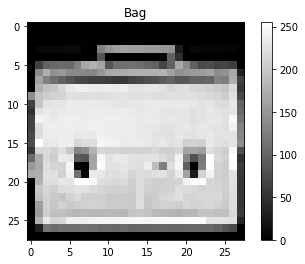

La probabilidad es del: 99.94 %
------------------------------------------


In [223]:
muestreo_aleatorio(imagenes_prueba)